In [ ]:
import os
from os.path import join as osj
import sys
sys.path.insert(0, osj(os.getcwd(), "scripts"))

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
from lorenz63 import L63
from eakf import eakf_solver
from helper import *
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from gymnasium import spaces, Env
import gymnasium as gym
from stable_baselines3.common.callbacks import EvalCallback

device = torch.device("cpu")

# Step 1: generate underlying model

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


Text(0.5, 0.92, '3D Path Over Time')

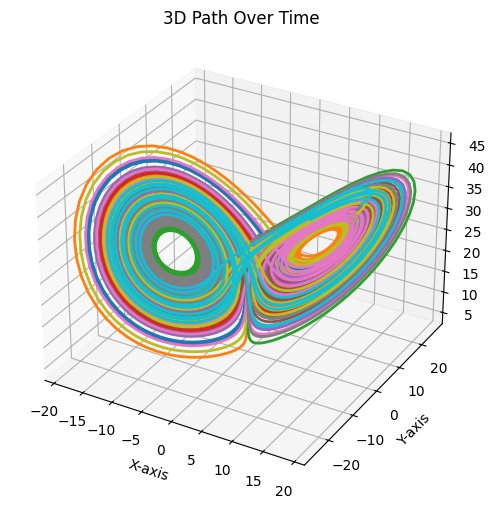

In [8]:
base_initial_condition = [10,20,30]
num_initial_conditions = 20
initial_conditions = generate_close_initial_conditions(base_initial_condition, num_initial_conditions)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for initial_condition in tqdm(initial_conditions):
    sigma, rho, beta = 10, 28, 8/3
    dt = 1e-2
    model = L63(sigma, rho, beta, dt)
    model.initialize([initial_condition[0],initial_condition[1],initial_condition[2]])
    for _ in range(1000):
        model.step()
    data = np.array(model.states)
    ax.plot(data[:,0], data[:,1], data[:,2], linewidth=2)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Path Over Time')


# Step 2: EnKF

In [ ]:
H = np.eye(3)
R = np.eye(3)
dtda = 1.0 # time between analyses
params = [10,28,8/3]
num_ensembles = 20
num_assimilations = 100
initial_conditions = [10,20,30]
solver = eakf_solver(params, initial_conditions, num_ensembles, L63)
sol = solver.run_eakf(H, R, dtda, num_assimilations)

100%|██████████| 100/100 [00:01<00:00, 51.90it/s]


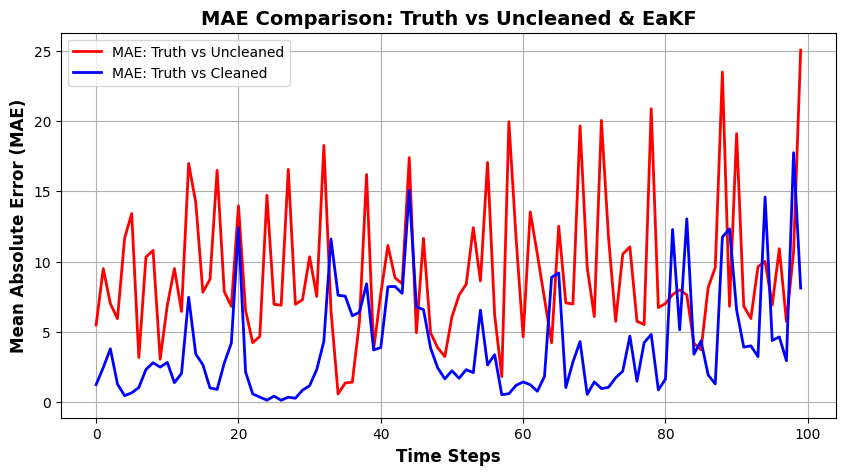

In [16]:
cleaned = sol['cleaned_states'][:,:,0]
uncleaned = sol['uncleaned_states'][:,:,0]
truth = sol['true_states']
mae_uncleaned = np.mean(np.abs(truth - uncleaned), axis=1)
mae_cleaned = np.mean(np.abs(truth - cleaned), axis=1)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(mae_uncleaned, label="MAE: Truth vs Uncleaned", linewidth=2, color='red')
plt.plot(mae_cleaned, label="MAE: Truth vs Cleaned", linewidth=2, color='blue')

plt.xlabel("Time Steps", fontsize=12, fontweight='bold')
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12, fontweight='bold')
plt.title("MAE Comparison: Truth vs Uncleaned & EaKF", fontsize=14, fontweight='bold')
plt.legend()
plt.grid()
plt.show()

# Step 3: Generate Sample Paths

In [19]:
H = np.eye(3)
R = np.eye(3)
dtda = 1.0 # time between analyses
params = [10,28,8/3]
num_ensembles = 20
num_assimilations = 1000
initial_conditions = np.random.randn(3)*100
solver = eakf_solver(params, initial_conditions, num_ensembles, L63)
sol = solver.run_eakf(H, R, dtda, num_assimilations)
np.save(osj(os.getcwd(), "data", "example.npy"), sol)

100%|██████████| 1000/1000 [00:19<00:00, 52.21it/s]


# Step 4: RL trainer using PPO

In [2]:
sol = np.load(osj(os.getcwd(), "data", "example.npy"), allow_pickle=True).item()

In [3]:
# 1) Define a custom MLP extractor using the ensemble strategy
class EnsembleMLPExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 3):
        super(EnsembleMLPExtractor, self).__init__(observation_space, features_dim)
        self.ensemble_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(observation_space.shape[0], 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, features_dim),
                nn.ReLU(),
                
            ) for _ in range(observation_space.shape[1])
        ])
        self.num_nets = observation_space.shape[1]
    
    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        bsz = observations.shape[0]
        output = torch.cat([self.ensemble_nets[i](observations[:,:,i]).unsqueeze(-1) for i in range(self.num_nets)], dim=-1).reshape(bsz,-1)
        return output
    
class IdentityMLPExtractor(nn.Module):
    def __init__(self, features_dim: int):
        super(IdentityMLPExtractor, self).__init__()
        self.features_dim = features_dim
        self.latent_dim_pi = 60
        self.latent_dim_vf = 60
    def forward(self, features):
        return self.forward_actor(features), self.forward_critic(features)
    def forward_actor(self, features):
        return features
    def forward_critic(self, features):
        return features
    
class EnsembleMLPPolicy(ActorCriticPolicy):
    def __init__(self,observation_space,action_space,lr_schedule,*args,**kwargs,):
        # Disable orthogonal initialization
        kwargs["ortho_init"] = False
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            **{"features_extractor_class": EnsembleMLPExtractor},
        )
    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = IdentityMLPExtractor(self.features_dim)

# 2) Define a custom environment
class L63RLAgent(Env):
    def __init__(self, solution_data, thresh=10000, deterministic=False):
        super(L63RLAgent, self).__init__()
        self.solution_data = solution_data
        self.num_ensembles = solution_data["cleaned_states"].shape[-1]
        self.timesteps = solution_data["true_states"].shape[0]
        self.idx = 0
        self.current_step = 0
        self.deterministic = deterministic
        
        # Define observation and action spaces
        vec_size = solution_data["true_states"].shape[1]
        self.observation_space = spaces.Box(low=-thresh, high=thresh, shape=(vec_size*4, self.num_ensembles), dtype=np.float32)
        self.action_space = spaces.Box(low=-thresh, high=thresh, shape=(vec_size*self.num_ensembles,), dtype=np.float32)
    
    def step(self, action):
        true_cleaned = self.solution_data["cleaned_states"][self.idx].flatten()
        
        # Compute reward as negative RMSE
        rmse = np.sqrt(np.mean((true_cleaned - action) ** 2))
        reward = -rmse
        
        # Sample new random step
        obs = self._get_obs()
        done = False  # Continuous process
        return obs, reward, done, False, {}
    
    def reset(self, seed=None, options=None):
        self.current_step = 0
        return self._get_obs(), {}
    
    def _get_obs(self):
        if self.deterministic:
            self.idx = (self.idx+1)%self.timesteps
        else:
            self.idx = np.random.randint(0, self.timesteps)  # Random step selection
        obs = np.concatenate([
            np.tile(np.expand_dims(self.solution_data['true_states'][self.idx], -1), 20),
            self.solution_data["uncleaned_states"][self.idx],
            self.solution_data["uncleaned_derivatives"][self.idx],
            self.solution_data["background_states"][self.idx]
        ], axis=0) # shape = (12, 20)
        return obs.astype(np.float32)

In [ ]:
# 3) Train the PPO model
total_timesteps = 50000
eval_freq = 1000

eval_callback = EvalCallback(
    L63RLAgent(sol, deterministic=True), 
    best_model_save_path=osj(os.getcwd(), "logs"),
    log_path=osj(os.getcwd(), "logs"), 
    eval_freq=eval_freq, 
    deterministic=True,
    render=False
)

model = PPO(
    EnsembleMLPPolicy,
    L63RLAgent(sol),
    verbose=1,
    device=device,
)
model.learn(
    total_timesteps=total_timesteps,
    progress_bar=True
)
model.save("lorenz63")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()